# Explore

### Imports

In [44]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Creating spark session

In [2]:
spark = SparkSession.builder.master('local').appName('explore').getOrCreate()

### Loading the data

In [4]:
df = spark.read.csv('sa311/case.csv', header=True, inferSchema=True)

In [5]:
df.show(5)

+----------+----------------+----------------+------------+---------+-------------------+-----------+----------------+--------------------+-----------+-----------+---------+--------------------+----------------+
|   case_id|case_opened_date|case_closed_date|SLA_due_date|case_late|      num_days_late|case_closed|   dept_division|service_request_type|   SLA_days|case_status|source_id|     request_address|council_district|
+----------+----------------+----------------+------------+---------+-------------------+-----------+----------------+--------------------+-----------+-----------+---------+--------------------+----------------+
|1014127332|     1/1/18 0:42|    1/1/18 12:29|9/26/20 0:42|       NO| -998.5087616000001|        YES|Field Operations|        Stray Animal|      999.0|     Closed| svcCRMLS|2315  EL PASO ST,...|               5|
|1014127333|     1/1/18 0:46|     1/3/18 8:11| 1/5/18 8:30|       NO|-2.0126041669999997|        YES|     Storm Water|Removal Of Obstru...|4.322222222| 

### Creating a random sample and loading it into a pandas dataframe.

In [32]:
pandas_df = df.sample(withReplacement=False, fraction=0.01, seed=123).toPandas()

In [33]:
pandas_df.head()

,case_id,case_opened_date,case_closed_date,SLA_due_date,case_late,num_days_late,case_closed,dept_division,service_request_type,SLA_days,case_status,source_id,request_address,council_district
0,1014127366,1/1/18 7:16,1/2/18 15:22,1/17/18 8:30,NO,-14.713391,YES,Code Enforcement,Front Or Side Yard Parking,16.050718,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",4
1,1014127614,1/1/18 15:41,1/1/18 22:37,1/6/18 15:41,NO,-4.711308,YES,Field Operations,Aggressive Animal(Non-Critical),5.000000,Closed,ns16326,"323 ARRID, San Antonio, 78210",3
2,1014127658,1/1/18 17:08,1/2/18 15:26,1/17/18 8:30,NO,-14.710625,YES,Code Enforcement,Front Or Side Yard Parking,15.639907,Closed,svcCRMSS,"10129 BOXING PASS, San Antonio, 78251",4
3,1014127740,1/1/18 19:27,1/1/18 19:33,1/3/18 8:30,NO,-1.539282,YES,Signals,Traffic Signal Ops and Maintenance - Emergency,1.543125,Closed,124405,NACOGDOCHES RD and WURZBACH PKWY,10
4,1014127902,1/2/18 7:28,1/2/18 10:30,1/2/18 10:28,YES,0.001840,YES,Field Operations,Animal Cruelty(Critical),0.125000,Closed,mt13131,"3342 LASSES, San Antonio, 78223",3


# Exploring a single variable
### Categorical Variable

### Creating a spark dataframe of the counts of case status.

In [23]:
sdf = df.groupBy('case_status').count().orderBy('case_status')

### Loading the counts into a pandas dataframe.

In [24]:
pdf = sdf.toPandas()

In [25]:
pdf.head()

,case_status,count
0,Closed,823594
1,Open,18110


### Creating barcharts.
One for all the data and one for the sample.

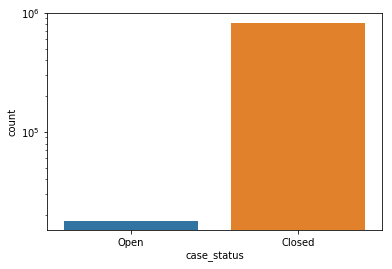

In [31]:
order = ['Open', 'Closed']
sns.barplot(x=pdf.case_status, y=pdf['count'], order=order)
plt.yscale('log')

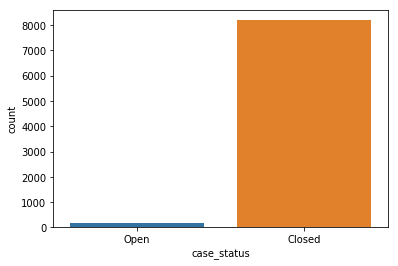

In [37]:
order = ['Open', 'Closed']
sns.countplot(x=pandas_df.case_status, data=pandas_df, order=order)


### Continuous Variable

### Using describe to compute basic summary statistics

In [39]:
df.describe('SLA_days').show()

+-------+------------------+
|summary|          SLA_days|
+-------+------------------+
|  count|            841671|
|   mean| 59.25478976660636|
| stddev|174.52559467491596|
|    min|             0.125|
|    max|            1420.0|
+-------+------------------+



### Aggregate functions can tell us additional statistics

In [42]:
df.agg(F.skewness('SLA_days'), F.kurtosis('SLA_days')).show()

+------------------+------------------+
|skewness(SLA_days)|kurtosis(SLA_days)|
+------------------+------------------+
| 4.983687199032779|23.983570974325893|
+------------------+------------------+



### A histogram is more informative than simple summary statistics
Use pandas to plot a histogram

In [45]:
pdf = df.select(col('SLA_days')).dropna().sample(False, 0.01, 123).toPandas()
pdf.head()

,SLA_days
0,16.050718
1,5.000000
2,15.639907
3,1.543125
4,0.125000


In [47]:
print(pdf.info())
pdf['SLA_days'] = pd.to_numeric(pdf['SLA_days'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8379 entries, 0 to 8378
Data columns (total 1 columns):
SLA_days    8379 non-null float64
dtypes: float64(1)
memory usage: 65.5 KB
None


### With matplotlib

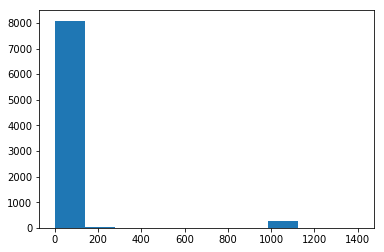

In [51]:
plt.hist(pdf['SLA_days'])
plt.show()

### With seaborn
Unnormalized

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


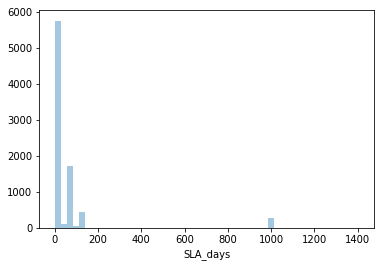

In [52]:
sns.distplot(pdf['SLA_days'], kde=False)
plt.show()

### With seaborn
Normalized with rug and kde

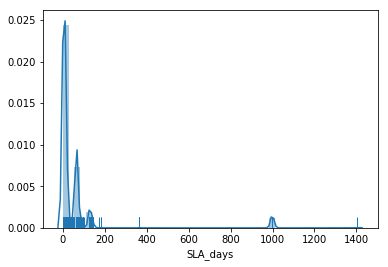

In [55]:
sns.distplot(pdf['SLA_days'], kde=True, rug=True)

### Boxplot displays information computed by spark method: `approxQuantile`

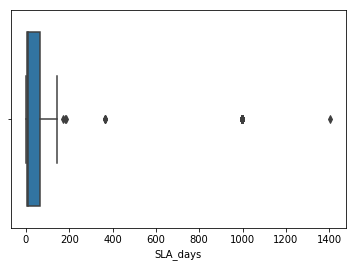

In [62]:
sns.boxplot('SLA_days', data=pdf)

### Exploring a pair of variables
### Categorical and Categorical

### Creating a two way frequency table

In [65]:
sdf = df.groupBy(['council_district', 'case_late']).count().orderBy(['council_district', 'case_late'])
sdf.show(5)

+----------------+---------+------+
|council_district|case_late| count|
+----------------+---------+------+
|               0|       NO|  3276|
|               0|      YES|   554|
|               1|       NO|107794|
|               1|      YES| 11515|
|               2|       NO|100173|
|               2|      YES| 14572|
|               3|       NO| 90907|
|               3|      YES| 11799|
|               4|       NO| 84631|
|               4|      YES|  9147|
|               5|       NO|102928|
|               5|      YES| 11681|
|               6|       NO| 64058|
|               6|      YES| 10037|
|               7|       NO| 63094|
|               7|      YES|  9351|
|               8|       NO| 37628|
|               8|      YES|  4717|
|               9|       NO| 36687|
|               9|      YES|  4229|
+----------------+---------+------+
only showing top 20 rows



In [66]:
pdf = sdf.toPandas()
pdf.head()

,council_district,case_late,count
0,0,NO,3276
1,0,YES,554
2,1,NO,107794
3,1,YES,11515
4,2,NO,100173


### Creating a bar chart using seaborn

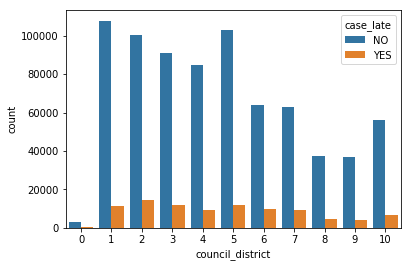

In [68]:
sns.barplot(data=pdf, x='council_district', y='count', hue='case_late')
plt.show()

### Taking care of missing values
by filling them with 'other/unknown'.

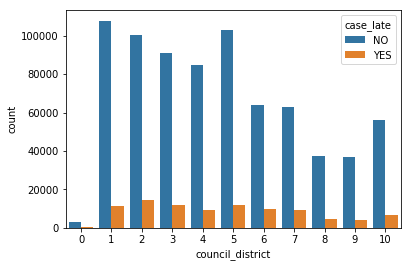

In [70]:
pdf = sdf.fillna('other/unknown').toPandas()
sns.barplot(data=pdf, x='council_district', y='count', hue='case_late')

### Categorical and Continuous

### Producing a tabular report

In [73]:
(df.groupBy('dept_division')
 .agg(F.count('SLA_days'), F.mean('SLA_days'), F.stddev('SLA_days'))
 .orderBy('dept_division')
 .show(5))

+--------------------+---------------+------------------+---------------------+
|       dept_division|count(SLA_days)|     avg(SLA_days)|stddev_samp(SLA_days)|
+--------------------+---------------+------------------+---------------------+
|     311 Call Center|           2849| 8.050333019700954|   1.7190007222063597|
|               Brush|          18212| 7.624494589446555|     3.38475153846676|
|     Clean and Green|           1248| 6.675153254474361|    4.515779720725676|
|Clean and Green N...|             82| 7.808043558000003|    1.589338370125451|
|    Code Enforcement|         272305|56.071701766366886|    36.34313500309739|
+--------------------+---------------+------------------+---------------------+
only showing top 5 rows



### Producing visualizations on a sample

In [75]:
sample_pdf = (df.select('dept_division', 'SLA_days')
              .sample(False, 0.01, 12345)
              .toPandas())

In [77]:
sample_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8422 entries, 0 to 8421
Data columns (total 2 columns):
dept_division    8422 non-null object
SLA_days         8422 non-null float64
dtypes: float64(1), object(1)
memory usage: 131.7+ KB


In [78]:
sample_pdf['SLA_days'] = pd.to_numeric(sample_pdf.SLA_days)

### Making a barplot and pointplot

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


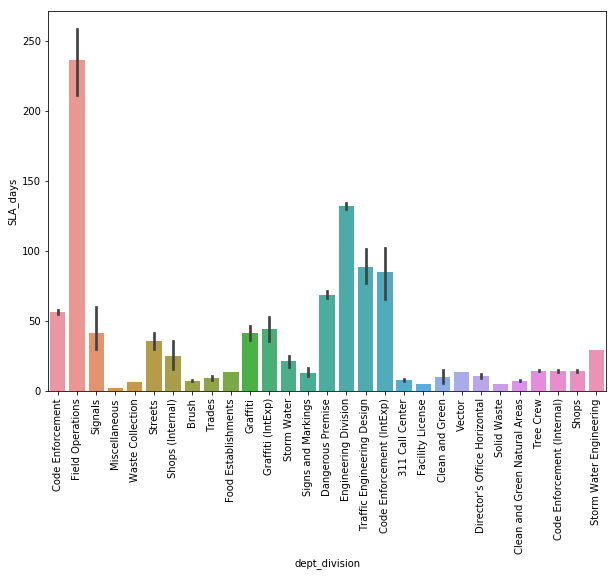

In [82]:
plt.figure(figsize=(10, 7))
sns.barplot(data=sample_pdf, x='dept_division', y='SLA_days')
plt.xticks(rotation=90)
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


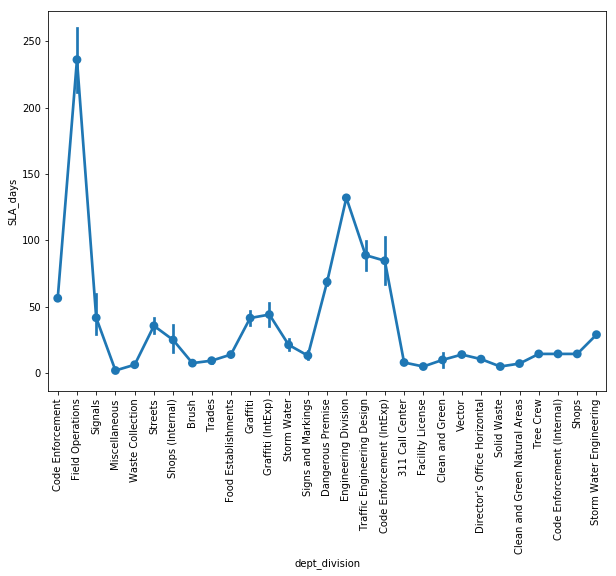

In [84]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=sample_pdf, x='dept_division', y='SLA_days')
plt.xticks(rotation=90)
plt.show()

### Strip plot

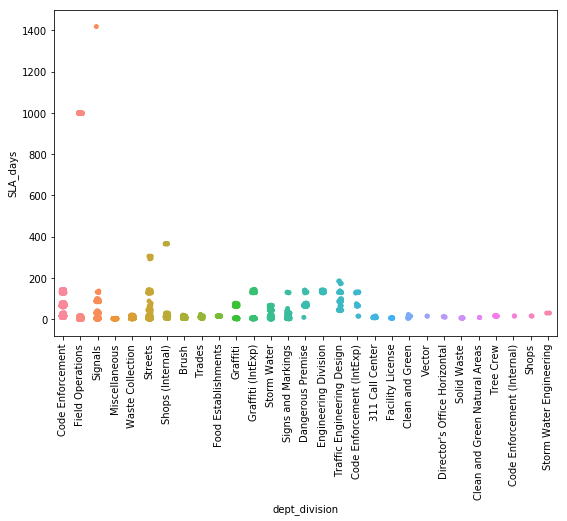

In [97]:
plt.figure(figsize=(9, 6))
sns.stripplot(data=sample_pdf, x='dept_division', y='SLA_days', jitter=True)
plt.xticks(rotation=90)
plt.show()

### Letter value plot

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


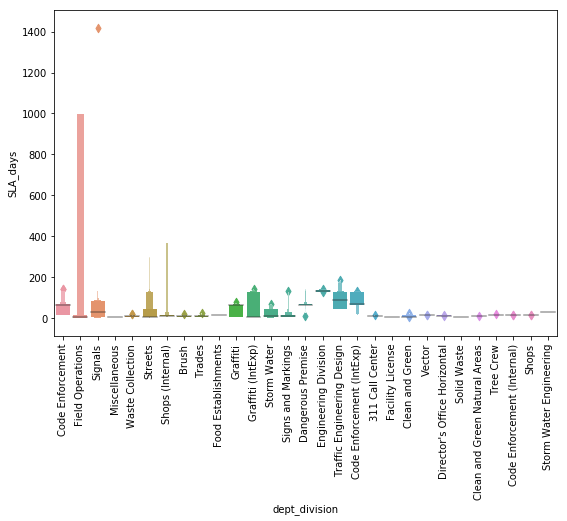

In [100]:
plt.figure(figsize=(9, 6))
sns.lvplot(data=sample_pdf, x='dept_division', y='SLA_days')
plt.xticks(rotation=90)
plt.show()

### Boxplot

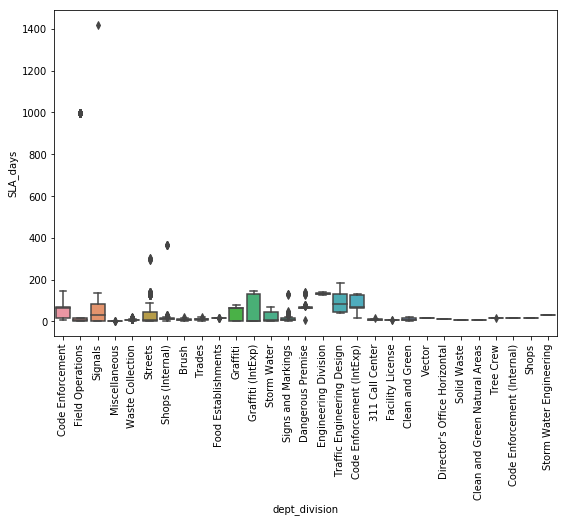

In [102]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=sample_pdf, x='dept_division', y='SLA_days')
plt.xticks(rotation=90)
plt.show()

### Violin plot

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


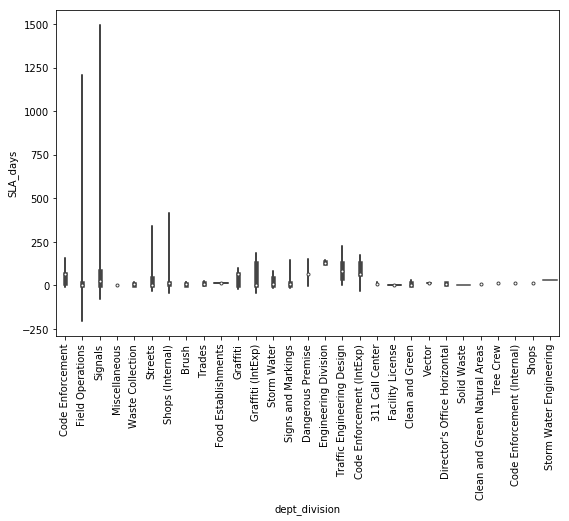

In [104]:
plt.figure(figsize=(9, 6))
sns.violinplot(data=sample_pdf, x='dept_division', y='SLA_days')
plt.xticks(rotation=90)
plt.show()

### Continuous and Continuous

### Use the corr, covar_samp, and covar_pop aggregate functions
to measure the linear relationship between two variables:

In [111]:
sdf = df.agg(F.corr('num_days_late', 'SLA_days'),
       F.covar_samp('num_days_late', 'SLA_days'), 
       F.covar_pop('num_days_late', 'SLA_days'))

In [112]:
sdf.toPandas().T

,0
"corr(num_days_late, SLA_days)",-0.988302
"covar_samp(num_days_late, SLA_days)",-30448.609474
"covar_pop(num_days_late, SLA_days)",-30448.573298


### Looking at the relationship between num_days_late and SLA_days

In [119]:
sample_pdf = (df.select('num_days_late', 'SLA_days')
              .sample(False, 0.01, 12345)
              .toPandas())

sample_pdf['num_days_late'] = pd.to_numeric(sample_pdf['num_days_late'])
sample_pdf['SLA_days'] = pd.to_numeric(sample_pdf['SLA_days'])

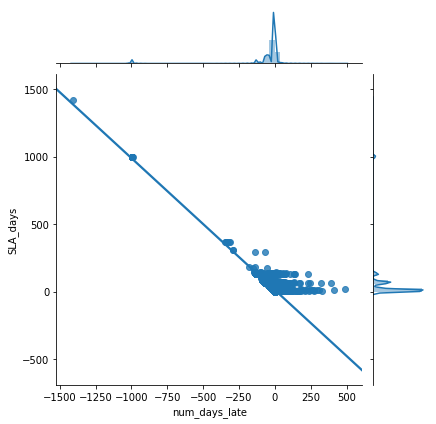

In [117]:
sns.jointplot(data=sample_pdf, x='num_days_late', y='SLA_days', kind='reg')
plt.show()

### Quadratic fit instead of linear. (order=2)

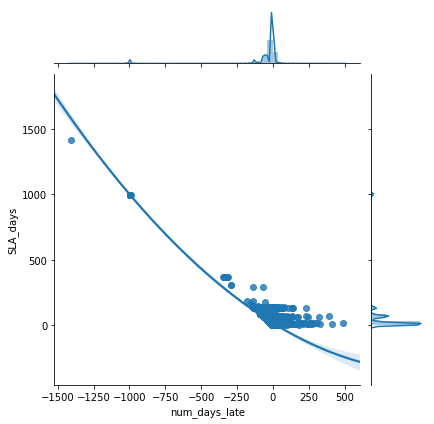

In [118]:
sns.jointplot(data=sample_pdf, x='num_days_late', y='SLA_days', kind='reg', order=2)
plt.show()

### Making a pairplot
Seaborn does not like Decimal types, so we have cast the columns to floats before converting to a pandas DataFrame.

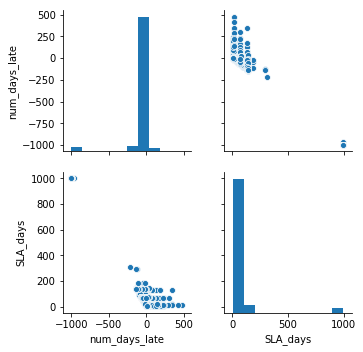

In [120]:
tmp_pdf = (df.select(col('num_days_late').cast("float"), col('SLA_days').cast("float"))
           .sample(False, 0.01)
           .toPandas())
sns.pairplot(tmp_pdf)

### Exploring more than two variables
### N-way summary tables
We can use grouping and aggregate functions in Spark to produce summaries.

### Three categorical variables

In [124]:
df.groupby('case_late', 'case_closed', 'council_district').count().orderBy(['case_late', 'case_closed']).show()

+---------+-----------+----------------+------+
|case_late|case_closed|council_district| count|
+---------+-----------+----------------+------+
|       NO|         NO|               4|  1108|
|       NO|         NO|               0|    49|
|       NO|         NO|               9|   494|
|       NO|         NO|              10|   853|
|       NO|         NO|               2|  1801|
|       NO|         NO|               1|  1536|
|       NO|         NO|               3|  1516|
|       NO|         NO|               6|  1327|
|       NO|         NO|               7|   851|
|       NO|         NO|               8|   519|
|       NO|         NO|               5|  1531|
|       NO|        YES|               2| 98372|
|       NO|        YES|               6| 62731|
|       NO|        YES|               7| 62243|
|       NO|        YES|               5|101397|
|       NO|        YES|               8| 37109|
|       NO|        YES|               1|106258|
|       NO|        YES|               9|

### Two categorical variables and one continuous

In [127]:
(df.cube('case_late', 'case_closed')
 .agg(F.grouping_id(), F.mean('num_days_late'), F.stddev('SLA_days'))
 .orderBy(['case_late', 'case_closed'])
 .show())

+---------+-----------+-------------+-------------------+---------------------+
|case_late|case_closed|grouping_id()| avg(num_days_late)|stddev_samp(SLA_days)|
+---------+-----------+-------------+-------------------+---------------------+
|     null|       null|            3|-49.074867583697205|   174.52559467491596|
|     null|         NO|            2|  -9.09733738151573|    83.56549024394552|
|     null|        YES|            2| -49.95252967719666|   175.99166661493285|
|       NO|       null|            1| -58.49713051774848|    184.2655760117578|
|       NO|         NO|            0| -53.77566981441864|    95.99130393471603|
|       NO|        YES|            0| -58.57130168391601|    185.3063178053263|
|      YES|       null|            1|  25.42026327891507|   27.371050484289523|
|      YES|         NO|            0|  70.02952998931192|    46.79660123315876|
|      YES|        YES|            0|  22.11176041131918|   24.081860981831667|
+---------+-----------+-------------+---

### Two categorical variables and two continuous

In [129]:
(df.groupBy('case_late', 'case_closed')
 .agg(F.corr('num_days_late', 'SLA_days'))
 .orderBy('case_late')
 .show())

+---------+-----------+-----------------------------+
|case_late|case_closed|corr(num_days_late, SLA_days)|
+---------+-----------+-----------------------------+
|       NO|         NO|          -0.9405426842862277|
|       NO|        YES|          -0.9976264563884775|
|      YES|        YES|          0.24758823875617345|
|      YES|         NO|         -0.08660806771227425|
+---------+-----------+-----------------------------+



### Faceted plots
Before we produce more visualizations, let us fill in the missing values for case_late using pandas functionality:

In [130]:
pandas_df['case_late'] = pandas_df['case_late'].fillna("missing")

### Three categorical variables

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


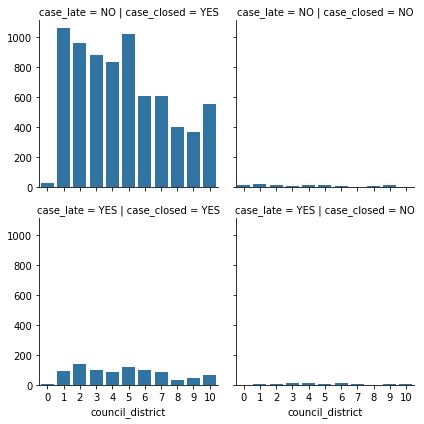

In [131]:
def tmp_plot():
    g = sns.FacetGrid(data=pandas_df, row='case_late', col='case_closed')
    g = g.map(sns.countplot, 'council_district')
tmp_plot()

### Two categorical variables and one continuous variable

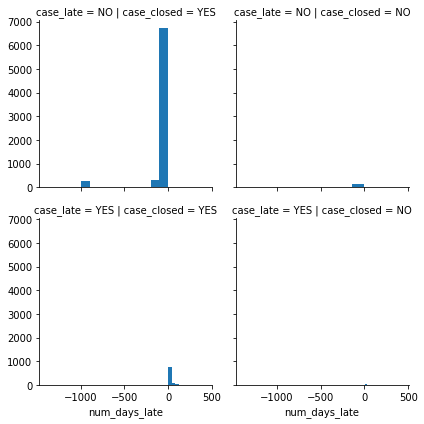

In [132]:
def tmp_plot():
    g = sns.FacetGrid(data=pandas_df, row='case_late', col='case_closed')
    g = g.map(plt.hist, 'num_days_late')
tmp_plot()

### Two categorical variables and two continuous variables

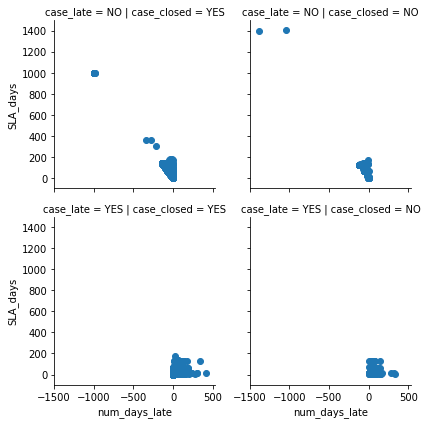

In [133]:
def tmp_plot(): 
    g = sns.FacetGrid(data=pandas_df, row='case_late', col='case_closed')
    g = g.map(plt.scatter, 'num_days_late', 'SLA_days')
tmp_plot()